In [ ]:
import numpy as np
%matplotlib inline
from matplotlib.pyplot import *
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab \Notebooks/tensorflow-experiment/great-barrier-reef
import data_utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/tensorflow-experiment/great-barrier-reef


In [ ]:


#copy class definition to make it easier to hack in place

class Backbone:

    # Start by downloading pretrained weights from the Tensorflow hub
    def __init__(self):
        # Instantiate the feature extractor.
        # This is the feature of this class we will actually want to use
        self.feature_extractor = hub.KerasLayer(
            "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
            trainable=True,
        )
        # TODO standardize the thumbnail sizes, I just hard coded in the feature sizes here and in data_utils.py
        self.thumbnail_detector = tf.keras.Sequential(
            [self.feature_extractor, tf.keras.layers.Dense(1, activation=None)] # sigmoid sits in loss function, I believe
        )
        self.thumbnail_detector.build([None, 128, 128, 3])

    def fine_tune(dataloader, epochs):
        pass
        

In [ ]:
thumbs=data_utils.DataLoaderThumbnail(input_file=r'/content/drive/MyDrive/Colab Notebooks/great-barrier-reef')
inputs = thumbs.get_training(validation_split=0.2, batch_size=64, shuffle=True)   #1m33s
valid = thumbs.get_validation(validation_split=0.2, batch_size=64, shuffle=False)

Found 23501 files belonging to 2 classes.
Using 18801 files for training.
Found 23501 files belonging to 2 classes.
Using 4700 files for validation.


In [ ]:

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

do_data_augmentation = False #let's not do any for now
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
  
inputs_aug = inputs.map(lambda images, labels:
                        (preprocessing_model(images), labels))
valid_aug = valid.map(lambda images, labels:
                        (preprocessing_model(images), labels))

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0.]')

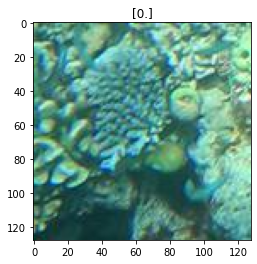

In [ ]:
test = inputs_aug.as_numpy_iterator().next()
test, label = test[0][:1], test[1][0]
imshow(test[0])
title(label)

In [ ]:
# for speed, try making model output a single float per image (likelihood of being a starfish) and use BinaryCrossEntropy loss instead
model = Backbone().thumbnail_detector
model.summary()
#model.compile(
#  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#  loss=tf.keras.losses.SparseCategoricalCrossentropy())
#  metrics=['accuracy']) 

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['binary_accuracy']) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              54336736  
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
steps_per_epoch = len(inputs_aug) // 64
validation_steps = len(valid_aug) // 64
hist = model.fit(
    inputs_aug,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_aug,
    validation_steps=validation_steps).history

Epoch 1/10
9/9 [==============================] - 66s 4s/step - loss: 1.1746 - binary_accuracy: 0.7639 - val_loss: 22.2408 - val_binary_accuracy: 0.2344
Epoch 2/10
9/9 [==============================] - 19s 2s/step - loss: 1.0818 - binary_accuracy: 0.8264 - val_loss: 1.5337 - val_binary_accuracy: 0.7500
Epoch 3/10
9/9 [==============================] - 23s 3s/step - loss: 1.0173 - binary_accuracy: 0.8368 - val_loss: 11.3834 - val_binary_accuracy: 0.7344
Epoch 4/10
9/9 [==============================] - 24s 3s/step - loss: 0.8807 - binary_accuracy: 0.8646 - val_loss: 5.1096 - val_binary_accuracy: 0.6875
Epoch 5/10
9/9 [==============================] - 24s 3s/step - loss: 0.8674 - binary_accuracy: 0.8715 - val_loss: 73.1321 - val_binary_accuracy: 0.7344
Epoch 6/10
9/9 [==============================] - 23s 3s/step - loss: 0.9045 - binary_accuracy: 0.8472 - val_loss: 83.4224 - val_binary_accuracy: 0.7969
Epoch 7/10
9/9 [==============================] - 23s 3s/step - loss: 0.7700 - binar

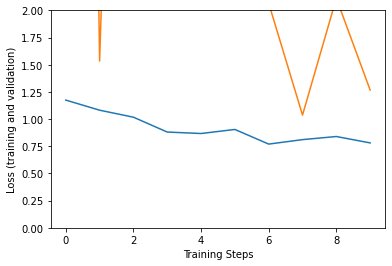

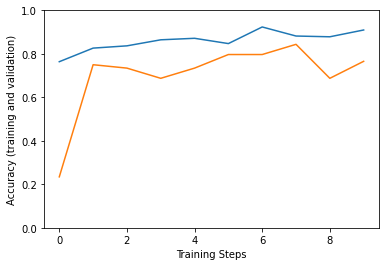

In [ ]:
import matplotlib.pyplot as plt
figure()
ylabel("Loss (training and validation)")
xlabel("Training Steps")
ylim([0,2])
plot(hist["loss"])
plot(hist["val_loss"])

figure()
ylabel("Accuracy (training and validation)")
xlabel("Training Steps")
ylim([0,1])
plot(hist["binary_accuracy"])
plot(hist["val_binary_accuracy"])